In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [15]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [16]:
class IrishData(Dataset):
    def __init__(self, X_train, y_train) -> None:
        super().__init__()
        self.X = torch.from_numpy(X_train)
        self.y = torch.from_numpy(y_train)
        self.y = self.y.type(torch.LongTensor)
        self.len = self.X.shape[0]
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.len

In [17]:
irish_data=IrishData(X_train=X_train, y_train=y_train)
train_loader = DataLoader(dataset=irish_data, batch_size=32)

In [19]:
class MultiClassNet(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN_FEATURES):
        super().__init__()
        self.lin1 = nn.Linear(NUM_FEATURES, HIDDEN_FEATURES)
        self.lin2=nn.Linear(HIDDEN_FEATURES,NUM_CLASSES)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.lin1(x)
        x = torch.sigmoid(x)
        x = self.lin2(x)
        x = self.log_softmax(x)
        return x
    
        

In [20]:
NUM_FEATURES=irish_data.X.shape[1]
HIDDEN=6
NUM_CLASSES=len(irish_data.y.unique())


In [21]:
model = MultiClassNet(NUM_FEATURES=NUM_FEATURES, NUM_CLASSES=NUM_CLASSES, HIDDEN_FEATURES=HIDDEN)

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
lr=0.1
optimizer=torch.optim.SGD(model.parameters(), lr=lr)

In [25]:
NUM_EPOCHS=100
losses=[]
for epoch in range(NUM_EPOCHS):
    for x, y in train_loader:
        # initialize gradients
        optimizer.zero_grad()
        # forward pass
        y_hat_log = model(x)
        # calculate losses
        loss = criterion(y_hat_log, y)
        # calculate gradients
        loss.backward()
        # update parameters
        optimizer.step()
    # append losses
    losses.append(loss.item())
    # Debugging: print loss and parameter values every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        # print(f"Slope: {model.lin1.weight.item()}, Bias: {model.lin1.bias.item()}")
        for param in model.parameters():
            print(param)

Epoch 0, Loss: 1.0308873653411865
Parameter containing:
tensor([[ 0.2231, -0.1545, -0.2075,  0.2740],
        [-0.1079, -0.3379, -0.3385, -0.1130],
        [-0.2520, -0.3012,  0.4400,  0.3403],
        [ 0.0446, -0.2097, -0.0477,  0.4544],
        [-0.2722,  0.2405, -0.1157, -0.3311],
        [-0.3599, -0.1627, -0.2439, -0.0461]], requires_grad=True)
Parameter containing:
tensor([-0.3360,  0.3101,  0.0646,  0.1571, -0.3662,  0.3834],
       requires_grad=True)
Parameter containing:
tensor([[-0.1249,  0.2883, -0.2478,  0.1813,  0.3863,  0.1328],
        [ 0.3760, -0.1764, -0.3884,  0.3942, -0.2642,  0.3004],
        [-0.0183, -0.2274,  0.3298,  0.3822,  0.0151, -0.1029]],
       requires_grad=True)
Parameter containing:
tensor([0.2979, 0.0970, 0.0519], requires_grad=True)


<Axes: >

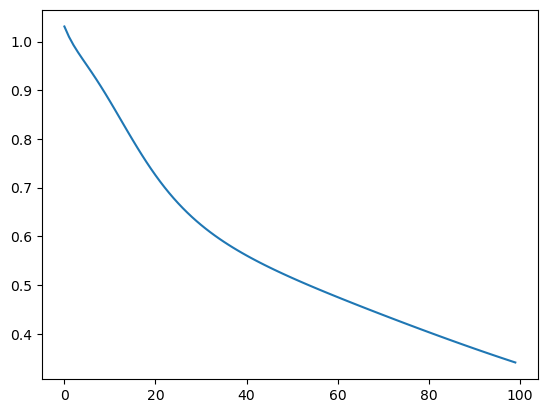

In [26]:
sns.lineplot(x= range(len(losses)), y = losses)

In [27]:
X_test_torch = torch.from_numpy(X_test)

In [29]:
with torch.no_grad():
    y_test_hat_softmax = model(X_test_torch)
    y_test_hat=torch.max(y_test_hat_softmax.data, 1)

In [30]:
accuracy_score(y_test, y_test_hat.indices)

0.9333333333333333

In [31]:
from collections import Counter
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {most_common_cnt / len(y_test) * 100} %")

Naive Classifier: 36.666666666666664 %


In [32]:
torch.save(model.state_dict(), 'artifacts/model_iris.pth')